In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import collections
from scipy.spatial.distance import cdist
from sklearn.metrics import fowlkes_mallows_score

from datasets_generator import *

## DBSCAN algorithm

###### Points classification
<ul>
    <li>A point p is a <b>core point</b> if at least <i>MinPts</i> points are within distance <i>Eps</i> of it, including p.</li>
    <li>A <b>border point</b> is not a core point, but fall within the neighborhhod of the core point.</li>
    <li>All points not reachable from any other point are outliers or <b>noise points</b>.</li>
</ul><br>
In the image below, point A is a core point, for the indicated radius (<i>Eps</i>) if <i>MinPts</i> &le; 7. B is not a core point but is reachacle from A, so it is considered as border point. Point C is a noise point because is not reachable from any other points.
<img src="gif/point_type_80.png" title="Core, border, noise points.">

### Pseudocode
1. Label all poist as core, border, or noise points.
2. Eliminate noise points.
3. Put an edge between all core points that are within *Eps* of each other.
4. Make each group of connected core points a separate cluster.
5. Assign each border point to one of the clusters of its associated corepoints.

In [2]:
def DBSCAN(X, Eps, MinPts):
    labels = np.full((X.shape[0],), -1).astype(int)
    all_distance = cdist(X, X, metric='euclidean')
    
    corePts = [] #index list of the poit marked ad CORE
    edgePts = [] #index list of the poit marked ad EDGE
    
    # PART 1
    # Label all point as core, border, or noise points
    for idx in range(X.shape[0]):
        num_neighbors = (all_distance[idx, : ] <= Eps).sum()
        if num_neighbors > MinPts:
            labels[idx] = 0         #mark as core_point
            corePts.append(idx)
    
    for idx in range(X.shape[0]):
        if labels[idx] == 0: #core_point
            continue
        for near_pos, is_near in enumerate(all_distance[idx, :] < Eps):
            if is_near and labels[near_pos]==0:
                labels[idx] = 1       #mark as border_point
                edgePts.append(idx)
                break
    
    # PART 3
    # Connect all core_points that are within Eps of each other
    edges = collections.defaultdict(list) #dictionary that contain for each CORE point a list of neighbour core points
    for idx in corePts:
        for idj in corePts:
            if all_distance[idx, idj] < Eps:
                edges[idx].append(idj)
    
    # PART 4
    #Make each group of connected core points into a separate cluster
    clusters = np.zeros(labels.shape).astype(int)
    id_clster = 1
    
    for i in corePts:
        stack = [i]
        while len(stack)!=0:
            p = stack.pop()
            if clusters[p]: #point already assign to a cluster
                continue
            clusters[p] = id_clster
            stack = stack + edges[p]
        id_clster += 1
        
    
    # PART 5
    #Assign each border point to one of the clusters of its associated core
    for idx in edgePts:
        for near_pos in np.where(all_distance[idx, :] < Eps)[0]:
            if labels[near_pos]==0:
                clusters[idx] = clusters[near_pos]
    
    return labels, clusters

In [3]:
"""
Technique to automatically determine the optimal Eps value

This technique calculates the average distance between each point and its k nearest neighbors, 
where k = the MinPts value you selected. The average k-distances are then plotted in ascending order 
on a k-distance graph. You’ll find the optimal value for ε at the point of maximum curvature 
(i.e. where the graph has the greatest slope).
https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
"""
def best_eps(data, minPts):
    all_distance = np.sort(cdist(X, X, metric='euclidean'))
    avg_dist = np.zeros((data.shape[0],))
    
    for i in range(data.shape[0]):
        avg_dist[i] = sum(all_distance[i,1:minPts+1]) / minPts
    
    avg_dist = np.sort(avg_dist)
    slope = [avg_dist[i] - avg_dist[i-1] for i in range(1, data.shape[0])]
    max_slope = np.argmax(slope)
    
    #plt.plot(avg_dist)
    #plt.scatter(max_slope, avg_dist[max_slope], c="red")
    
    return avg_dist[max_slope-1]

### Dataset generation without noise

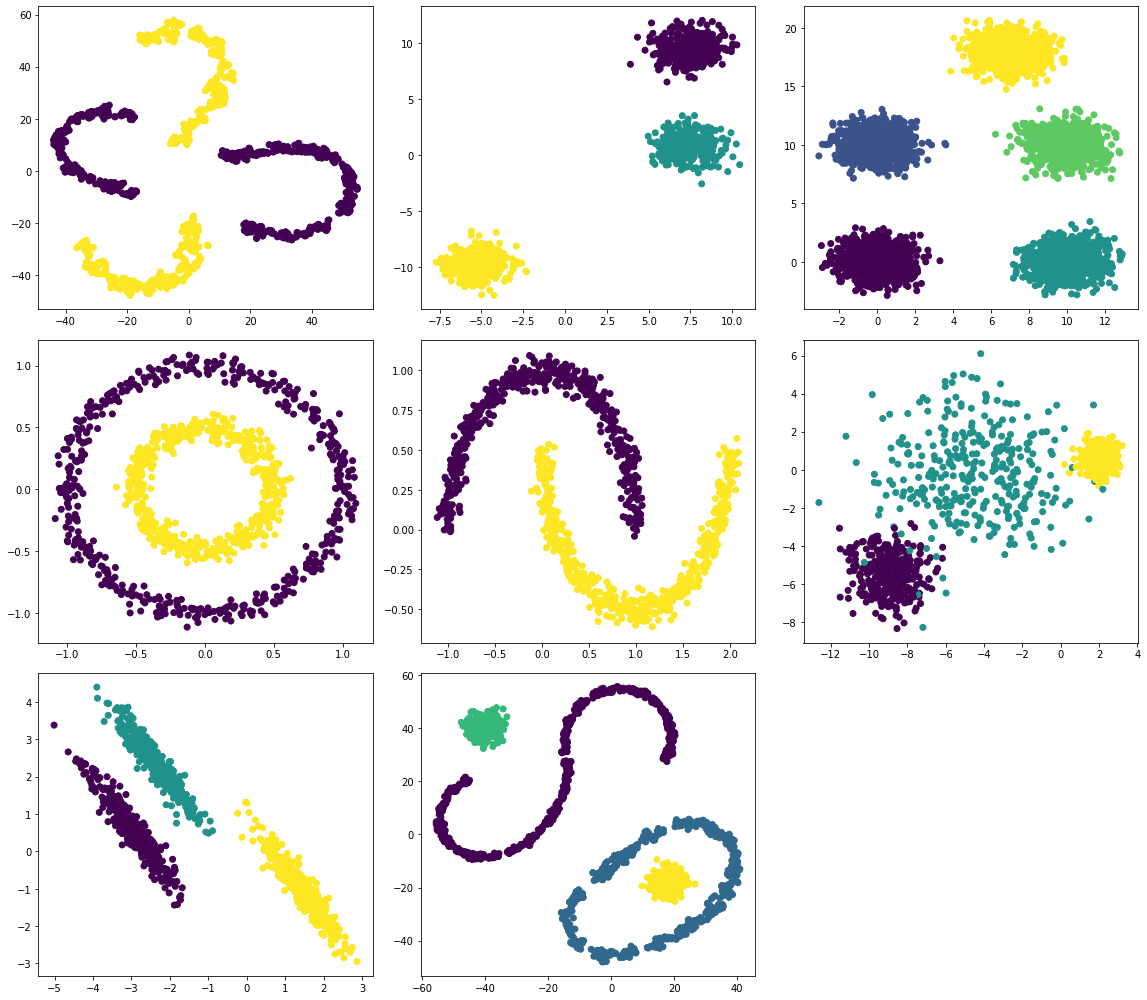

In [4]:
datasets = [dataset_1(), dataset_2(), dataset_3(),
            dataset_4(), dataset_5(), dataset_6(),
            dataset_7(), dataset_8()]

plt.figure(figsize=(16, 14))

for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    
    plt.subplot(math.ceil(len(datasets)/3), 3, i_dataset+1)
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
plt.tight_layout()

### Test & Evaluation

In [5]:
def plot_cluster(X, labels, clts):
    cluster_list = set(clts)
    colors = cm.rainbow(np.linspace(0, 1, len(cluster_list)))
    
    cls=0
    for id_cluster, color in zip(cluster_list, colors):    
        pos = list(np.where(clts==id_cluster)[0])
        if id_cluster:
            label = "cluster_"+str(cls); cls+=1
        else:
            label = "noise"
            color = "black"
        plt.scatter(X[pos, 0], 
                    X[pos, 1], c=np.array([color]), label=label)

###### Clustering with Eps automatically selected

1.953852465498954, 1.1789960310990992, 0.9578191720907369, 0.09745037484915044, 0.07980845567642642, 1.8399700419496066, 0.4112506735019441, 2.7526336657908717, 

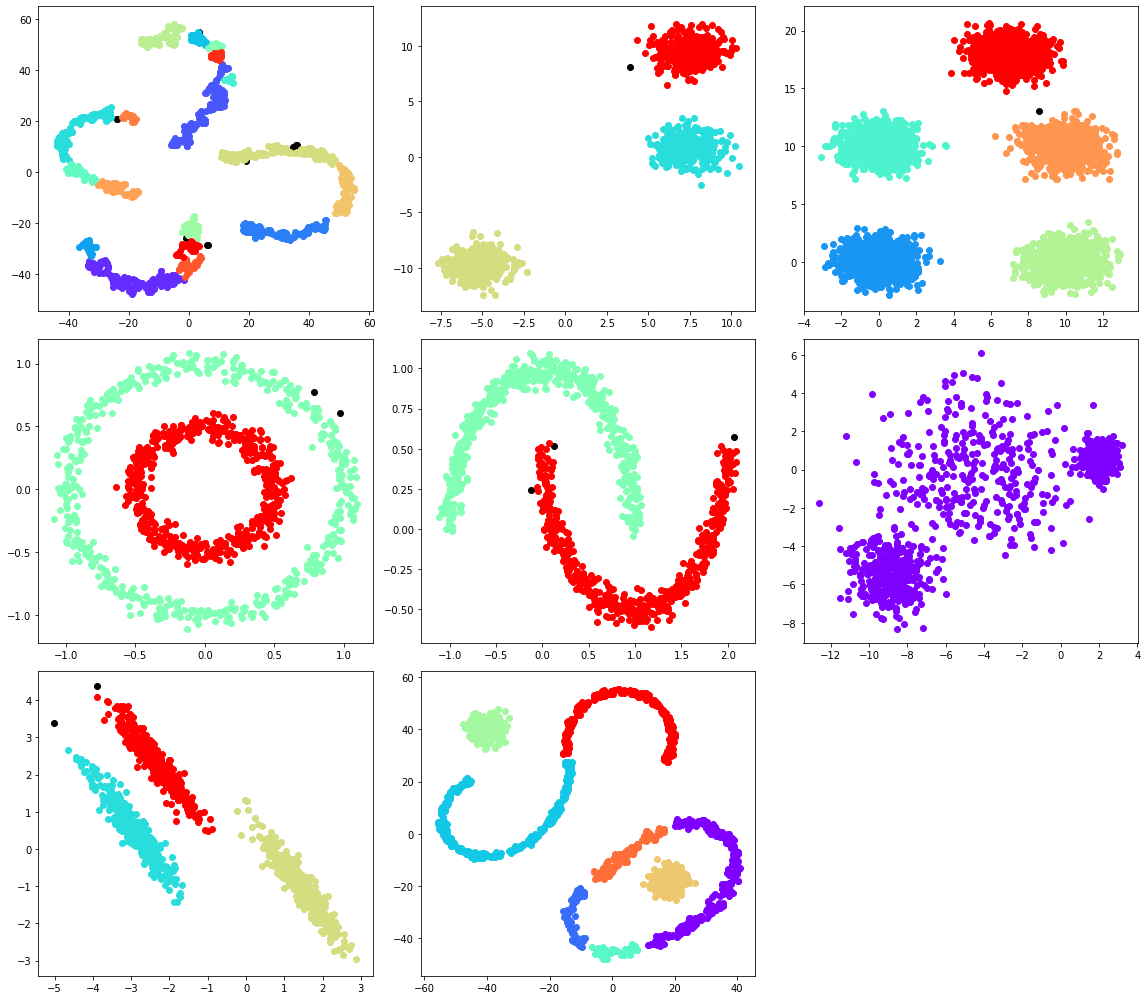

In [6]:
plt.figure(figsize=(16, 14))

for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    
    MinPts = 4
    Eps = best_eps(X, MinPts)
    print(Eps, end=", ")
    
    labels, clts = DBSCAN(X, Eps, MinPts)
    
    plt.subplot(math.ceil(len(datasets)/3), 3, i_dataset+1)
    plot_cluster(X, labels, clts)
plt.tight_layout()

###### Clustering with Eps selected manually

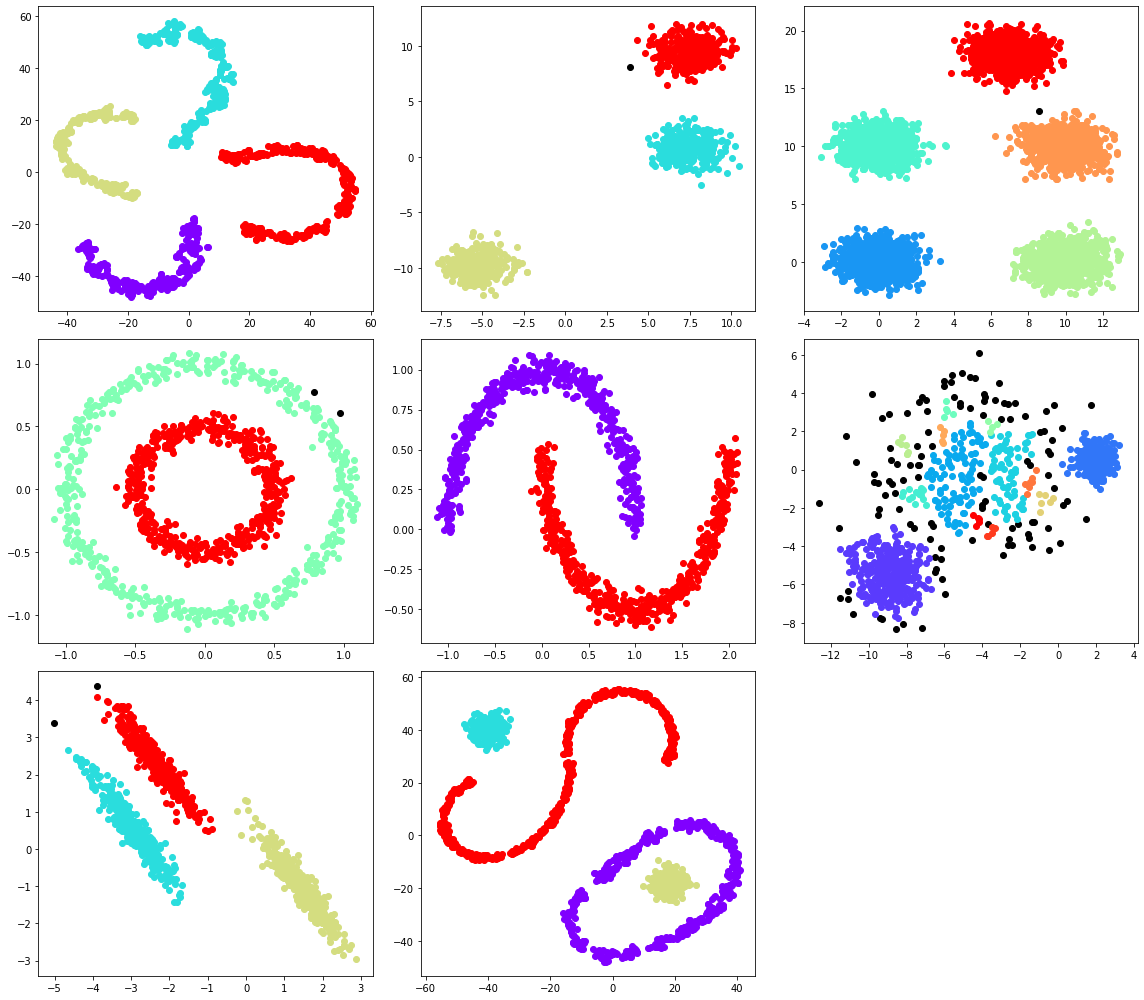

In [7]:
plt.figure(figsize=(16, 14))

MinPts = 4    
eps_list = [4.5000000000000000, 1.1789960310990992, 1.059950363082811,
             0.10047126855381942, 0.11155240671298629, 0.5000000000000,
             0.4112506735019441, 4.5]

for i_dataset, (dataset,Eps) in enumerate(zip(datasets, eps_list)):
    X, y = dataset
    
    labels, clts = DBSCAN(X, Eps, MinPts)
    
    plt.subplot(math.ceil(len(datasets)/3), 3, i_dataset+1)
    plot_cluster(X, labels, clts)
plt.tight_layout()

### Dataset generation with noise

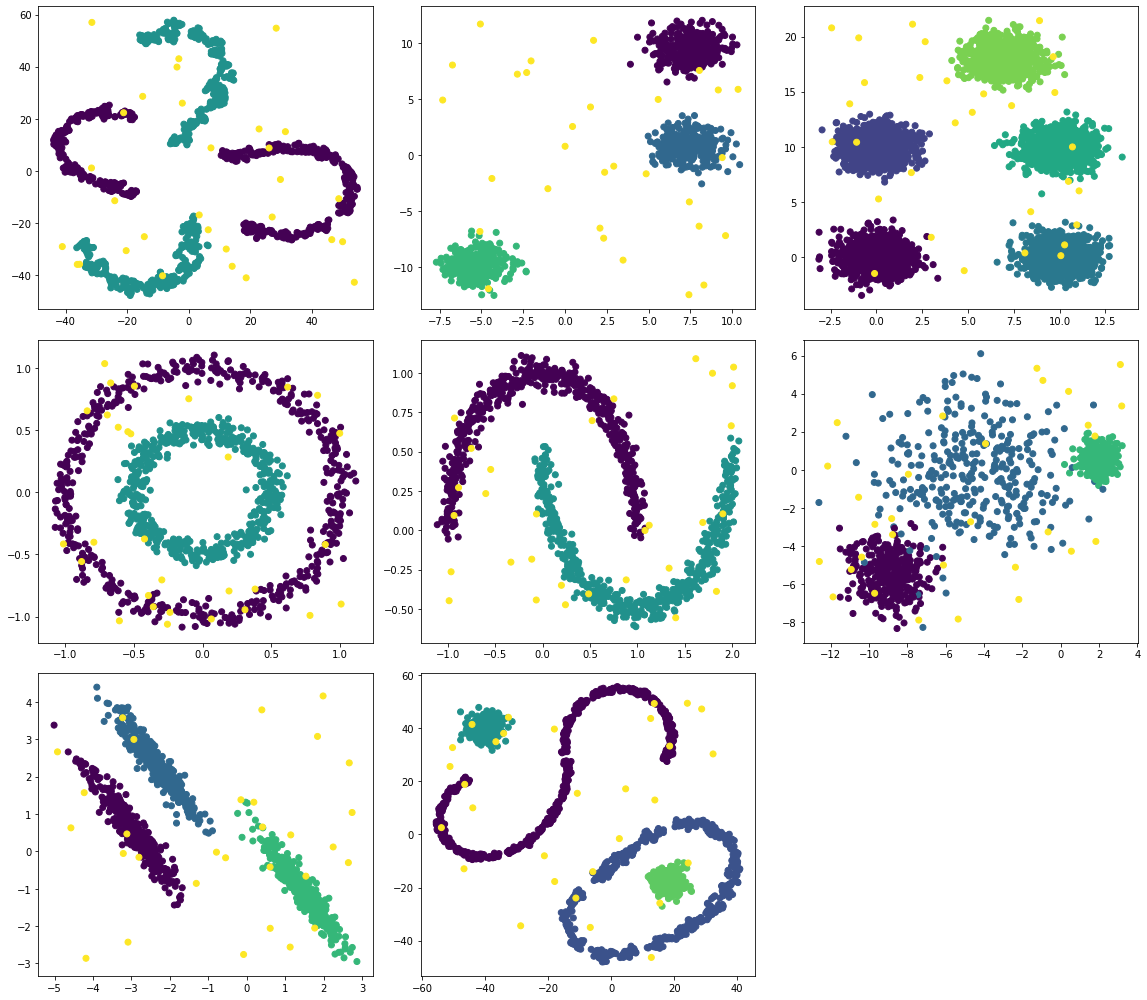

In [8]:
num_noisePts = 30

datasets = [dataset_1(noise=num_noisePts), dataset_2(noise=num_noisePts), dataset_3(noise=num_noisePts),
            dataset_4(noise=num_noisePts), dataset_5(noise=num_noisePts), dataset_6(noise=num_noisePts),
            dataset_7(noise=num_noisePts), dataset_8(noise=num_noisePts)]

plt.figure(figsize=(16, 14))

for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    
    plt.subplot(math.ceil(len(datasets)/3), 3, i_dataset+1)
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
plt.tight_layout()

###### Clustering with Eps automatically selected

11.33532828415625, 4.520529650842674, 2.8400343633810263, 0.18473178890797454, 0.13014958967356202, 1.965513369350163, 0.9300099387348777, 9.362367917070065, 

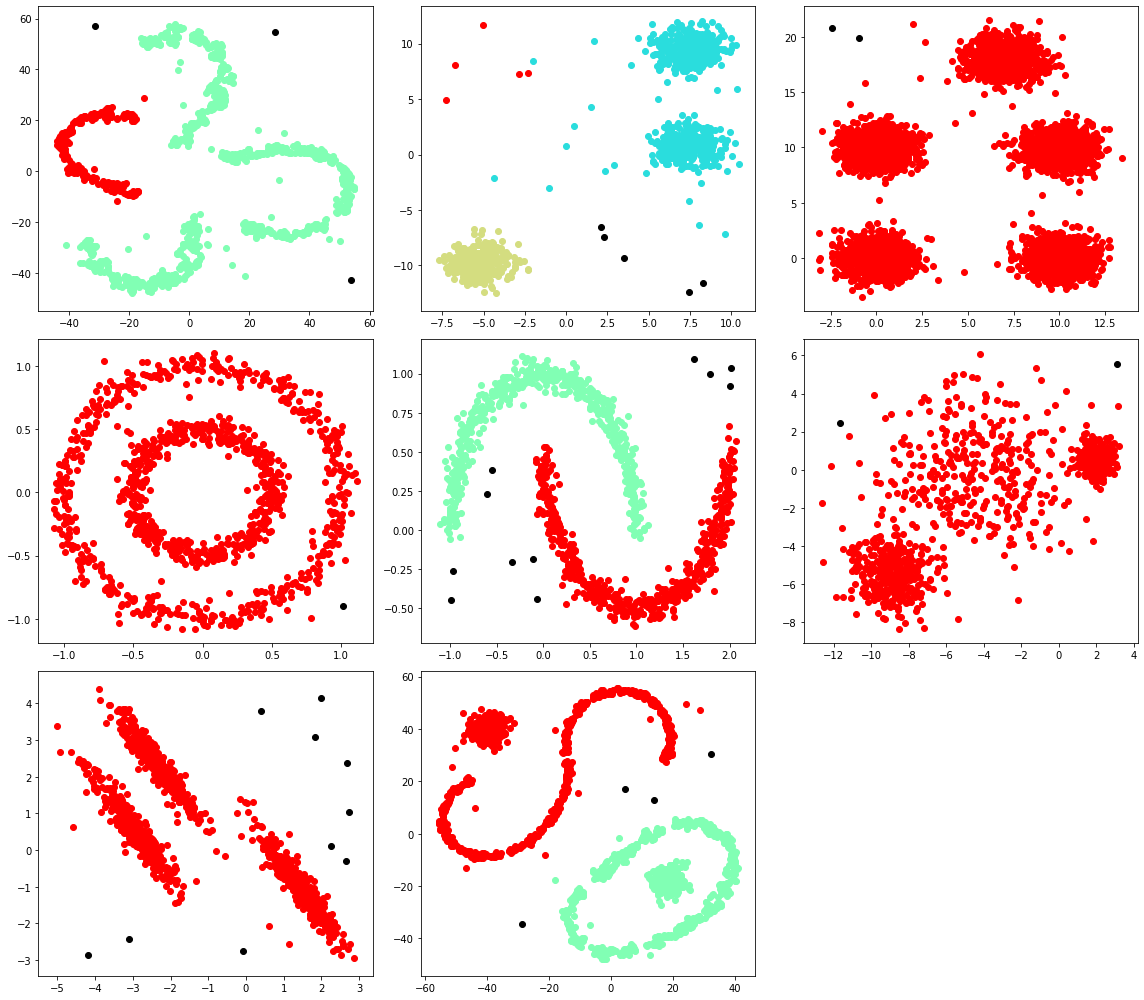

In [9]:
plt.figure(figsize=(16, 14))

for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    
    MinPts = 4
    Eps = best_eps(X, MinPts)
    print(Eps, end=", ")
    
    labels, clts = DBSCAN(X, Eps, MinPts)
    
    plt.subplot(math.ceil(len(datasets)/3), 3, i_dataset+1)
    plot_cluster(X, labels, clts)
plt.tight_layout()

###### Clustering with Eps selected manually

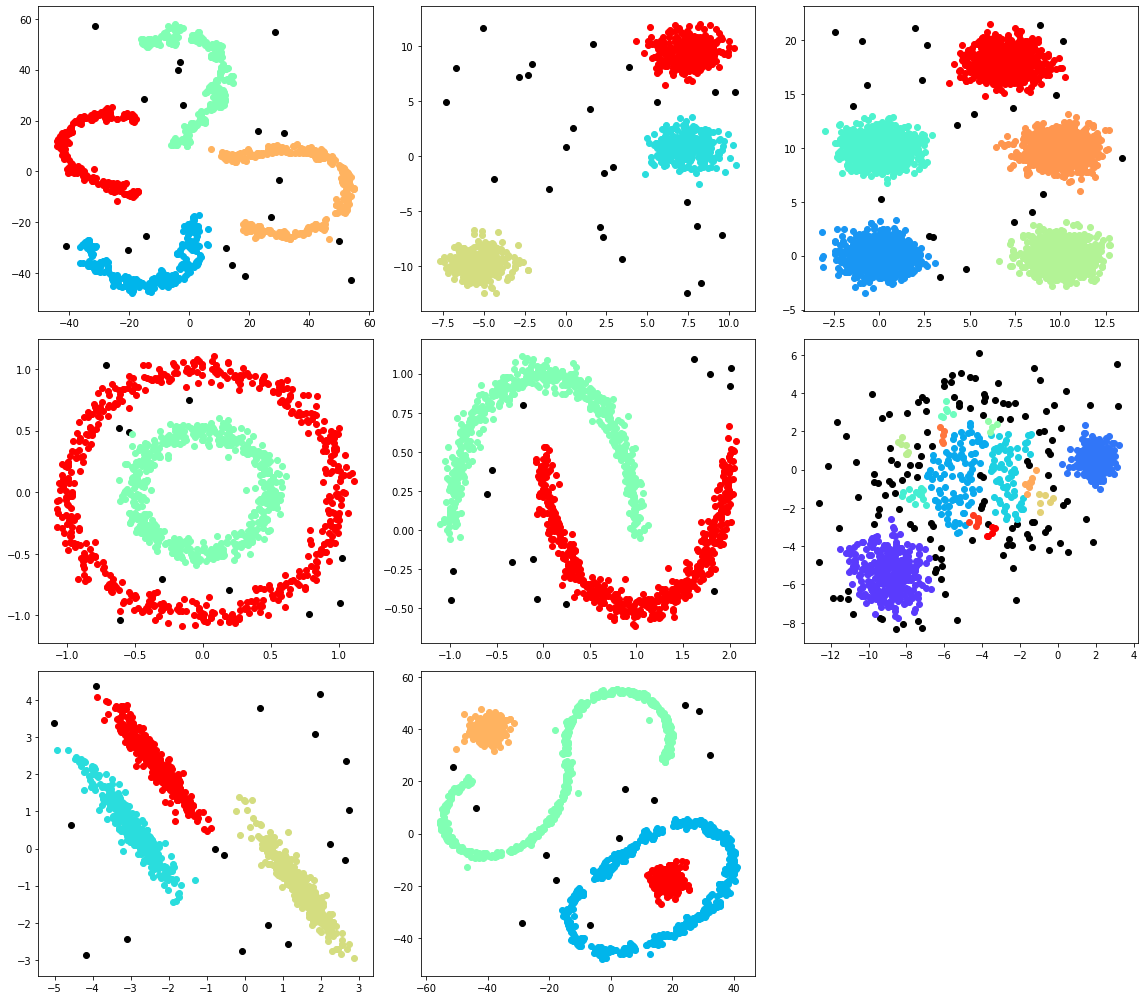

In [10]:
plt.figure(figsize=(16, 14))

MinPts = 4    
eps_list = [4.5000000000000000, 1.1789960310990992, 1.059950363082811,
            0.10047126855381942, 0.11155240671298629, 0.5000000000000,
            0.4112506735019441, 4.5]

for i_dataset, (dataset,Eps) in enumerate(zip(datasets, eps_list)):
    
    X, y = dataset
    labels, clts = DBSCAN(X, Eps, MinPts)
    
    plt.subplot(math.ceil(len(datasets)/3), 3, i_dataset+1)
    plot_cluster(X, labels, clts)
plt.tight_layout()